# Import

In [1]:
from copy import deepcopy
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from scipy.interpolate import griddata
import seaborn as sns

C:\Users\niels\AppData\Local\Temp\ipykernel_20708\713604176.py:5: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


# Code for Merging Files

In [ ]:
# # path = "C:\\Users\\niels\\Downloads\\CPPN_runs\\CSV"
# # path = "C:\\Users\\niels\\Downloads\\GRN_runs\\CSV"
# # path = "C:\\Users\\niels\\Downloads\\GRN_system_runs\\Random"
# # path = "C:\\Users\\niels\\Downloads\\GRN_system_adv_runs\\Random"
# path = "C:\\Users\\niels\\Downloads\\GRN_system_runs\\evolution\\CSV"
# # Create empty dataframe
# df = pd.DataFrame([])

# # Get folders
# folders = os.listdir(path)
# folders = [folder for folder in folders if os.path.isdir(os.path.join(path, folder))]
# assert len(folders) == 10, "Should be 10 folders"

# # Get files
# for folder in folders:
#     print("Processing folder: ", folder)
#     # Get files
#     files = os.listdir(os.path.join(path, folder))
#     if os.path.isdir(os.path.join(path, folder, files[0])) and (len(files) == 1):
#         files_new = os.listdir(os.path.join(path, folder, files[0]))
#         files = [files[0] + "\\" + file for file in files_new]

#     files2concat = []
#     for file in files:
#         print("\t\tProcessing file: ", file)
#         if file.endswith(".csv"):
#             # Get data
#             try:
#                 df_new = pd.read_csv(os.path.join(path, folder, file))
#                 # Set experiment name
#                 if "CPPN" in path:
#                     encoding = file.split("_opt")[1].split("_")
#                     exp_id = (int(encoding[0]) - 1) * 2 + int(encoding[1])
#                     df_new["experiment_id"] = exp_id
#                 elif "GRN" in path:
#                     check = file.split("_300_")[1].split("_")
#                     if len(check) == 2:
#                         encoding = (int(folder) - 1) * 2 + df_new["experiment_id"]
#                         df_new["experiment_id"] = encoding
#                     else:
#                         exp_id = (int(check[0]) - 1) * 2 + int(check[1])
#                         df_new["experiment_id"] = exp_id
#                 files2concat.append(df_new)
#             except Exception as e:
#                 pass
#     # Add to dataframe
#     df = pd.concat(files2concat + [df], ignore_index=True)
            

In [ ]:
# with open(path + "\\Morphology.csv", "w") as f:
#     df.to_csv(f, index=False)

# Settings

In [2]:
# Paths
path_root = "D:\\AI"
paths = {"GRN": {"Random Search": "D:\\AI\\Random\\GRN", "Evolution": "C:\\Users\\niels\\Downloads\\GRN_runs\\CSV"},
                 "CPPN": {"Random Search": "D:\\AI\\Random\\CPPN", "Evolution": "C:\\Users\\niels\\Downloads\\CPPN_runs\\CSV"},
                 "GRN_system": {"Random Search": "C:\\Users\\niels\\Downloads\\GRN_system_runs\\Random",
                                "Evolution": "C:\\Users\\niels\\Downloads\\GRN_system_runs\\evolution\\CSV"},}
# Mapping for column names
mappings = {'bricks': "Number of Bricks", 'hinges': "Number of Hinges", 'modules': "Modules", 
            'size': "Relative Number of Modules", 'proportion2d': "Proportion2D",
            "proportionNiels": "Proportion2D_adapted", 'single_neighbour_brick_ratio': "Single_Neighbour_Bricks", 
            'single_neighbour_ratio': "Single Neighbours", 'double_neighbour_brick_and_active_hinge_ratio': "Double_Neighbours",
            'maxrel_llimbs': 'Attachment Length Max', 'meanrel_llimbs': 'Attachment Length Mean', 
            'stdrel_llimbs': "Attachment Length Std", 'nlimbs': "Core Attachments",
            'joints': 'Number of Joints', 'joint_brick_ratio': 'Joint-Brick Ratio',
            "surface_area": "Surface Area"}

# Import Data

In [3]:
# Get data
df_exp = pd.DataFrame([])
for algorithm, algodata in paths.items():
    for mode, path in algodata.items():
        for file in os.listdir(path):
            if file.endswith(".csv"):
                # Load data
                df_new = pd.read_csv(path + "\\" + file)
                df_new["Algorithm"] = algorithm
                df_new["Mode"] = mode

                # Check and select data
                if mode == "Evolution":
                    # Assert that 600 generations are present
                    for exp_id in df_new.loc[:, "experiment_id"].unique():
                        assert len(df_new.loc[df_new["experiment_id"] == exp_id, "generation_index"].unique()) == (1200 + 1)

                    # Assert that all even generations have 100 individuals
                    assert df_new.loc[df_new["generation_index"] % 2 == 0, :].groupby(["experiment_id", "generation_index"]).size().unique() == 100
                    # Assert that all uneven generations have 50 individuals
                    assert df_new.loc[df_new["generation_index"] % 2 != 0, :].groupby(["experiment_id", "generation_index"]).size().unique() == 50

                elif mode == "Random Search":
                    # Only gen = 0 and offspring
                    df_new = df_new.loc[(df_new.loc[:, "generation_index"] % 2 != 0) | (df_new.loc[:, "generation_index"] == 0), :]
                    df_new["generation_index"] = df_new.loc[:, "generation_index"].values - (df_new.loc[:, "generation_index"].values // 2)
                    
                    # Assert that all experiments have 51 generations
                    for exp_id in df_new.loc[:, "experiment_id"].unique():
                        assert len(df_new.loc[df_new["experiment_id"] == exp_id, "generation_index"].unique()) == 51
                    
                    
                    # Assert that all generations have 50 individuals if not generation 0
                    assert df_new.loc[df_new["generation_index"] != 0, :].groupby(["experiment_id", "generation_index"]).size().unique() == 50
                    # Assert that generation 0 has 100 individuals
                    assert df_new.loc[df_new["generation_index"] == 0, :].groupby(["experiment_id", "generation_index"]).size().unique() == 100

                # Assert that 20 reps are present
                assert len(df_new.loc[:, "experiment_id"].unique()) == 20

                # Append to existing data
                df_exp = pd.concat([df_exp, df_new], ignore_index=True)

# Rename columns
df_exp = df_exp.rename(columns=mappings)

In [4]:
# Load Random Data
path2random = "C:\\Users\\niels\\Downloads\\Random_runs"

# Get data
df_random = pd.DataFrame([])
for file in os.listdir(path2random):
    if ("morphological_measures_" in file) and (file.endswith(".csv")):
        df_random_new = pd.read_csv(path2random + "\\" + file)
        assert df_random_new["count"].sum() == 60000
        df_random = pd.concat([df_random, df_random_new], ignore_index=True)

# Rename columns
df_random = df_random.rename(columns=mappings)
df_random["Algorithm"] = "Random"

# Concatenate data
df_exp = pd.concat([df_exp, df_random], ignore_index=True)

In [8]:
# Get maximal symmetry
df_exp["Symmetry_incl_max"] = df_exp.loc[:, ['symmetry_incl1', 'symmetry_incl2','symmetry_incl3', 'symmetry_incl4']].max(axis = 1)
df_exp["Symmetry_excl_max"] = df_exp.loc[:, ['symmetry_excl1', 'symmetry_excl2','symmetry_excl3', 'symmetry_excl4']].max(axis = 1)
# Get median symmetry
df_exp["Symmetry_incl_median"] = df_exp.loc[:, ['symmetry_incl1', 'symmetry_incl2','symmetry_incl3', 'symmetry_incl4']].median(axis = 1)
df_exp["Symmetry_excl_median"] = df_exp.loc[:, ['symmetry_excl1', 'symmetry_excl2','symmetry_excl3', 'symmetry_excl4']].median(axis = 1)
# Get summation symmetry
df_exp["Symmetry_incl_sum"] = df_exp.loc[:, ['symmetry_incl1', 'symmetry_incl2','symmetry_incl3', 'symmetry_incl4']].sum(axis = 1) / 4
df_exp["Symmetry_excl_sum"] = df_exp.loc[:, ['symmetry_excl1', 'symmetry_excl2','symmetry_excl3', 'symmetry_excl4']].sum(axis = 1) / 4

# Get standard deviation symmetry
df_exp["Symmetry_incl_std"] = df_exp.loc[:, ['symmetry_incl1', 'symmetry_incl2','symmetry_incl3', 'symmetry_incl4']].std(axis = 1)
df_exp["Symmetry_excl_std"] = df_exp.loc[:, ['symmetry_excl1', 'symmetry_excl2','symmetry_excl3', 'symmetry_excl4']].std(axis = 1)

# Transform number of limbs
df_exp["Core Attachments"] = df_exp["Core Attachments"] / 4

In [ ]:
# col1 = "Number of Hinges"
# col2 = "Number of Bricks"

# xlwb = df_exp[col1].min()
# xupb = df_exp[col1].max()
# ylwb = df_exp[col2].min()
# yupb = df_exp[col2].max()

# plt.subplot(1, 3, 1, aspect='equal')
# df2 = df_exp.loc[df_exp["Algorithm"] == "Random"].sample(52000, weights = "count", replace = True)
# df2[col1] = (df2[col1] - xlwb)/(xupb - xlwb)
# df2[col2] = (df2[col2] - ylwb)/(yupb - ylwb)
# sns.kdeplot(data=df2, x=col1, y=col2, fill=True,)
# plt.title("Random")
# plt.xlim(0, 1)
# plt.ylim(0, 1)
# plt.xticks([])
# plt.yticks([])

# plt.subplot(1, 3, 2, aspect='equal')
# df3 = df_exp.loc[df_exp["Algorithm"] == "CPPN"]
# df3 = df3.loc[df3["Mode"] == "Random Search"]
# df3[col1] = (df3[col1] - xlwb)/(xupb - xlwb)
# df3[col2] = (df3[col2] - ylwb)/(yupb - ylwb)
# sns.kdeplot(data=df3, x=col1, y=col2, fill=True, color="red")
# plt.title("CPPN")
# plt.xlim(0, 1)
# plt.ylim(0, 1)
# plt.xlabel("")
# plt.ylabel("")
# plt.xticks([])
# plt.yticks([])

# plt.subplot(1, 3, 3, aspect='equal')
# df4 = df_exp.loc[df_exp["Algorithm"] == "GRN"]
# df4 = df4.loc[df4["Mode"] == "Random Search"]
# df4[col1] = (df4[col1] - xlwb)/(xupb - xlwb)
# df4[col2] = (df4[col2] - ylwb)/(yupb - ylwb)
# sns.kdeplot(data=df4, x=col1, y=col2, fill=True, color="orange")
# plt.title("GRN")
# plt.xlim(0, 1)
# plt.ylim(0, 1)
# plt.xlabel("")
# plt.ylabel("")
# plt.xticks([])
# plt.yticks([])


# #plt.plot(df2["Number of Hinges"], df2["surface_area"], 'o', markeredgecolor='red', markerfacecolor='none')

In [5]:
colsn2plot = ['symmetry_incl1', 'symmetry_incl2',
       'symmetry_incl3', 'symmetry_incl4', 'symmetry_excl1', 'symmetry_excl2',
       'symmetry_excl3', 'symmetry_excl4', "id_string", "experiment_id", "generation_index", "individual_index", "Mode", "Algorithm"]
columns2plot = list(df_exp.columns)
for col in colsn2plot:
    columns2plot.remove(col)

In [ ]:
algo = "GRN_system"
logarithmic = True
unique = False

# for icol, col1 in enumerate(columns2plot):
#     for col2 in columns2plot[icol + 1:]:
for i in range(1):
    for j in range(1):
        col1 = "Number of Hinges"
        col2 = "Number of Bricks"
        print(col1, col2)
        plt.figure(figsize=(10, 10))
        # ---- Get bounds
        col1lwb = df_exp[col1].min()
        col2lwb = df_exp[col2].min()
        col1upb = df_exp[col1].max()
        col2upb = df_exp[col2].max()

        # ---- Get granularity
        granularities = []
        for col in [col1, col2]:
            if col in ["Number of Hinges", "Number of Bricks", "Number of Modules", "Number of Limbs"]:
                granularities.append(1)
            else:
                granularities.append(0.01)

        # ---- Get df
        df = df_exp.loc[df_exp["Algorithm"] == algo]
        if algo == "Random":
            df = df.sample(30 * 60000, weights = "count", replace = True)
        else:
            #df = df.loc[df["Mode"] == "Random Search"]
            df = df.loc[df["Mode"] == "Evolution"]

        # ---- Get value counts
        if algo == "Random":
            if unique:
                df["values"] = df.groupby([col1, col2]).transform("size") # Unique counts
            else:
                df["values"] = df.groupby([col1, col2])["count"].transform("sum") # Nonunique counts
        else:
            if unique:
                df["values"] = df.drop_duplicates(["id_string"]).groupby([col1, col2]).transform("size") 
            else:
                df["values"] = df.groupby([col1, col2]).transform("size")

        df = df.drop_duplicates([col1, col2])
        if logarithmic:
            df["values"] = np.log(df["values"] + 1) # Logarithmic scale

        # ---- Get coordinates
        df["Row"] = (df[col1] / granularities[0]).round(2)
        df["Column"] = (df[col2] / granularities[1]).round(2)

        # ---- Add missing values
        rows2append, columns2append = [], []
        for row in range(int(np.round(col1lwb / granularities[0], 2)), int(np.round(col1upb / granularities[0] + 1, 2))):
            for column in range(int(np.round(col2lwb / granularities[1], 2)), int(np.round(col2upb / granularities[1] + 1, 2))):
                if (row, column) not in zip(df["Row"], df["Column"]):
                    rows2append.append(row)
                    columns2append.append(column)

        # Add to dataframe
        df2append = pd.DataFrame({"Row": rows2append, "Column": columns2append, "values": len(rows2append) * [0]})
        df = pd.concat([df, df2append], ignore_index=True).fillna(0)

        # ---- Scale columns
        df.loc[:, "Row"] = (df.loc[:, "Row"] * granularities[0] - col1lwb) / (col1upb - col1lwb)
        df.loc[:, "Column"] = (df.loc[:, "Column"] * granularities[1] - col2lwb) / (col2upb - col2lwb)

        # ---- Pivot table
        df = df.pivot_table(index="Row", columns="Column", values="values", aggfunc="sum", fill_value=0)

        # ---- Get the coordinates and values in the pivot table
        coordinates = []
        for i, index_label in enumerate(df.index):
            for j, column_label in enumerate(df.columns):
                coordinates.append((index_label, column_label))

        coordinates = np.array(coordinates)
        values = df.values.flatten()

        # ---- Creat a meshgrid
        mins = coordinates.min(axis = 0)
        maxs = coordinates.max(axis = 0)
        grid_x, grid_y = np.mgrid[mins[0]:maxs[0]:1000j, mins[1]:maxs[1]:1000j]

        # ---- Interpolate
        grid_z0 = griddata(coordinates, values, (grid_x, grid_y), method='cubic', fill_value = 0) # nearest, linear, cubic

        # ---- Plot
        plt.imshow(grid_z0.T, extent=(mins[0] - 0.05, maxs[0] + 0.05, mins[1] - 0.05, maxs[1] + 0.05), origin='lower', cmap = "jet")

        plt.xlabel(col1, fontsize = 16, fontweight = "bold", labelpad = 10)
        plt.ylabel(col2, fontsize = 16, fontweight = "bold", labelpad = 10)
        # if logarithmic:
        #     plt.title("Logarithmic scale", fontsize = 16, fontweight = "bold")
        # else:
        #     plt.title("Non-logarithmic scale", fontsize = 16, fontweight = "bold")
        # Remove ticks
        plt.xticks([])
        plt.yticks([])
        # Remove axes
        plt.gca().spines['top'].set_visible(False)
        plt.gca().spines['right'].set_visible(False)
        plt.gca().spines['left'].set_visible(False)
        plt.gca().spines['bottom'].set_visible(False)

        # Remove white padding surrounding the plot
        plt.margins(x = 0, y = 0)

        plt.savefig(f"D:\\AI\\Plots\\HeatMap\\Normal\\{algo}\\" + col1 + "_" + col2 + "_" + algo + ".png", 
                    bbox_inches='tight', dpi = 300, transparent=True)
        plt.show()


In [ ]:
from scipy.interpolate import griddata

col1 = "Number of Hinges"
col2 = "Number of Bricks"
logarithmic = True#False#True
unique = False #False

for algo in ["Random", "CPPN", "GRN", "GRN_system"]:
    df_transf = (df_exp.loc[:, [col1, col2]] - df_exp.loc[:, [col1, col2]].min(axis = 0)) / (df_exp.loc[:, [col1, col2]].max(axis = 0) - df_exp.loc[:, [col1, col2]].min(axis = 0))

    df = df_exp.loc[df_exp["Algorithm"] == algo]
    if algo == "Random":
        df = df.sample(30 * 60000, weights = "count", replace = True)
    else:
        df = df.loc[df["Mode"] == "Random Search"]#.sample(10000)#, weights = "count")

    # Get points
    points = (df.loc[:, [col1, col2]] - df_exp.loc[:, [col1, col2]].min(axis = 0)) / (df_exp.loc[:, [col1, col2]].max(axis = 0) - df_exp.loc[:, [col1, col2]].min(axis = 0))

    if algo == "Random":
        if unique:
            points["values"] = df.groupby([col1, col2]).transform("size") # Unique counts
        else:
            points["values"] = df.groupby([col1, col2])["count"].transform("sum") # Nonunique counts
    else:
        if unique:
            points["values"] = df.drop_duplicates(["id_string"]).groupby([col1, col2]).transform("size") 
        else:
            points["values"] = df.groupby([col1, col2]).transform("size")


    # Drop duplicates
    points = points.drop_duplicates([col1, col2])

    # Add non-existing points
    dict2add = {col1: [], col2: [], "values": []}
    added = []
    for key in df_transf.loc[:, [col1, col2]].groupby([col1, col2]).groups.keys():
        list_key = list(key)
        if list_key not in points.loc[:, [col1, col2]].values.tolist():
            if list_key not in added:
                dict2add[col1].append(list_key[0])
                dict2add[col2].append(list_key[1])
                dict2add["values"].append(0)
                added.append(list_key)

            # dict2add[col1].append(key[0])
            # dict2add[col2].append(key[1])
            # dict2add["values"].append(0)

    # Append to points
    points_new = pd.concat([points, pd.DataFrame(dict2add)], ignore_index=True)
        
    # Get values
    values = points_new["values"].values
    if logarithmic:
        values = np.log(values + 1) # Logarithmic scale
    coordinates = points_new.loc[:, [col1, col2]].values

    # Creat a meshgrid
    mins = coordinates.min(axis = 0)
    maxs = coordinates.max(axis = 0)
    grid_x, grid_y = np.mgrid[mins[0]:maxs[0]:1000j, mins[1]:maxs[1]:1000j]

    # Interpolate
    grid_z0 = griddata(coordinates, values, (grid_x, grid_y), method='cubic', fill_value = 0) # nearest, linear, cubic

    # Plot
    plt.imshow(grid_z0.T, extent=(mins[0] - 0.05, maxs[0] + 0.05, mins[1] - 0.05, maxs[1] + 0.05), origin='lower', cmap = "jet")
    #plt.scatter(coordinates[:, 0], coordinates[:, 1], c = "k")
    plt.xlabel(col1, fontsize = 16, fontweight = "bold")
    plt.ylabel(col2, fontsize = 16, fontweight = "bold")
    if logarithmic:
        plt.title("Logarithmic scale", fontsize = 16, fontweight = "bold")
    else:
        plt.title("Non-logarithmic scale", fontsize = 16, fontweight = "bold")

    #plt.plot(points[col1], points[col2], 'o', markeredgecolor='grey', markerfacecolor='none', markersize = 5)
    plt.show()

# Create Folder

In [ ]:
paths4plots = [f"{path_root}\\Plots\\LinePlots\\GRN vs CPPN\\Evolution", f"{path_root}\\Plots\\LinePlots\\GRN vs CPPN\\Random Search",
               f"{path_root}\\Plots\\Violin\\GRN vs CPPN\\Random Search\\Unique",
               f"{path_root}\\Plots\\Violin\\GRN vs CPPN\\Random Search\\All",
               f"{path_root}\\Plots\\Violin\\GRN vs CPPN\\Evolution\\Unique\\Offspring",
               f"{path_root}\\Plots\\Violin\\GRN vs CPPN\\Evolution\\All\\Offspring",
               f"{path_root}\\Plots\\Violin\\GRN vs CPPN\\Evolution\\Unique\\Population",
               f"{path_root}\\Plots\\Violin\\GRN vs CPPN\\Evolution\\All\\Population",
               f"{path_root}\\Plots\\Niches\\Evolution", f"{path_root}\\Plots\\Niches\\Random Search",
               f"{path_root}\\Plots\\Niches\\Across_Runs\\Evolution\\GRN", f"{path_root}\\Plots\\Niches\\Across_Runs\\Random Search\\GRN",
               f"{path_root}\\Plots\\Niches\\Across_Runs\\Evolution\\CPPN", f"{path_root}\\Plots\\Niches\\Across_Runs\\Random Search\\CPPN",
               f"{path_root}\\Plots\\HeatMap\\Line\\Evolution\\CPPN", f"{path_root}\\Plots\\HeatMap\\Line\\Evolution\\GRN"

               ]
for path in paths4plots:
    if not os.path.exists(path):
        os.makedirs(path)

# Set columns to plot

In [9]:
colsn2plot = ['count', 'symmetry_incl1', 'symmetry_incl2',
       'symmetry_incl3', 'symmetry_incl4', 'symmetry_excl1', 'symmetry_excl2',
       'symmetry_excl3', 'symmetry_excl4', "id_string", "experiment_id", "generation_index", "individual_index", "Mode", "Algorithm"]
columns2plot = list(df_exp.columns)
for col in colsn2plot:
    columns2plot.remove(col)

# Plot Data over Time

Number of Bricks
Number of Bricks
Number of Bricks


C:\Users\niels\AppData\Local\Temp\ipykernel_4780\37756053.py:44: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  plt.xlim(0, 601)
C:\Users\niels\AppData\Local\Temp\ipykernel_4780\37756053.py:44: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  plt.xlim(0, 601)


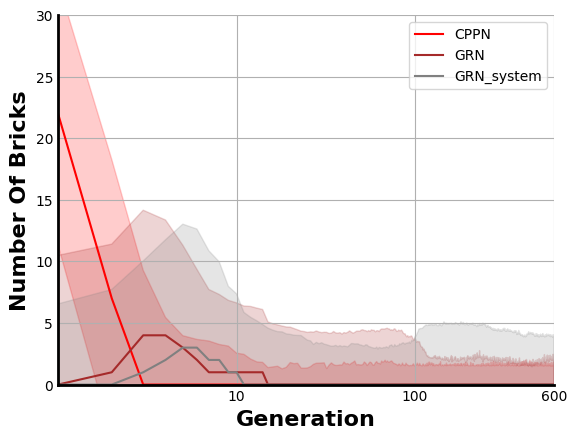

Number of Hinges
Number of Hinges
Number of Hinges


C:\Users\niels\AppData\Local\Temp\ipykernel_4780\37756053.py:44: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  plt.xlim(0, 601)
C:\Users\niels\AppData\Local\Temp\ipykernel_4780\37756053.py:44: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  plt.xlim(0, 601)


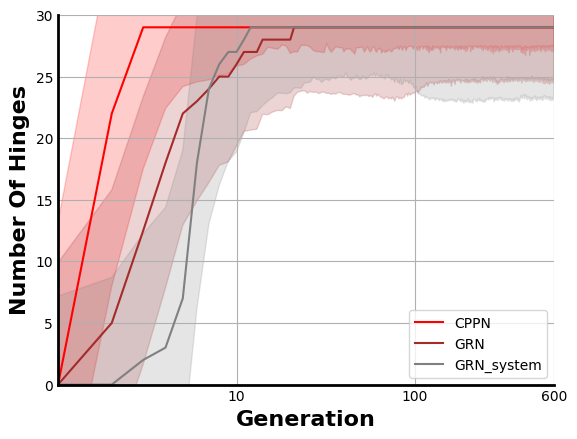

Modules
Modules
Modules


C:\Users\niels\AppData\Local\Temp\ipykernel_4780\37756053.py:44: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  plt.xlim(0, 601)
C:\Users\niels\AppData\Local\Temp\ipykernel_4780\37756053.py:44: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  plt.xlim(0, 601)


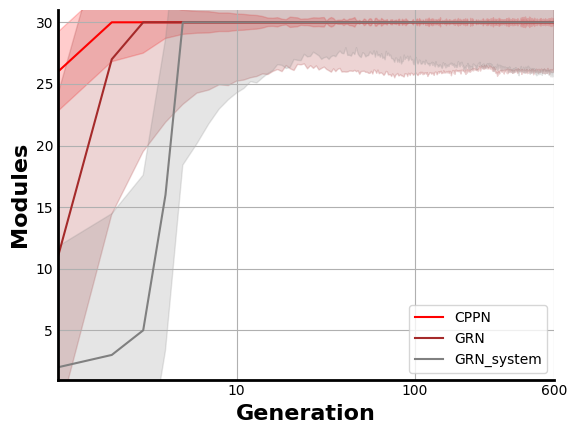

Relative Number of Modules
Relative Number of Modules
Relative Number of Modules


C:\Users\niels\AppData\Local\Temp\ipykernel_4780\37756053.py:44: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  plt.xlim(0, 601)
C:\Users\niels\AppData\Local\Temp\ipykernel_4780\37756053.py:44: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  plt.xlim(0, 601)


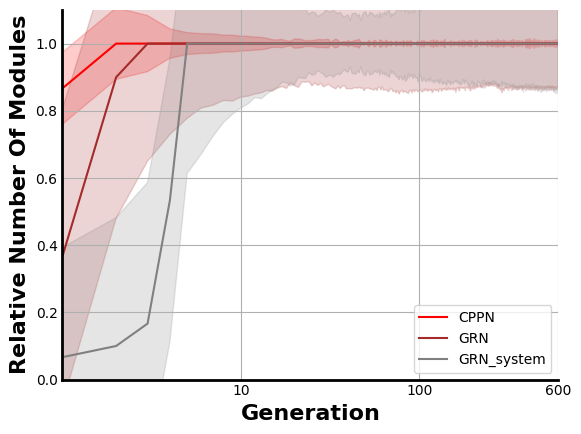

Proportion2D
Proportion2D
Proportion2D


C:\Users\niels\AppData\Local\Temp\ipykernel_4780\37756053.py:44: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  plt.xlim(0, 601)
C:\Users\niels\AppData\Local\Temp\ipykernel_4780\37756053.py:44: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  plt.xlim(0, 601)


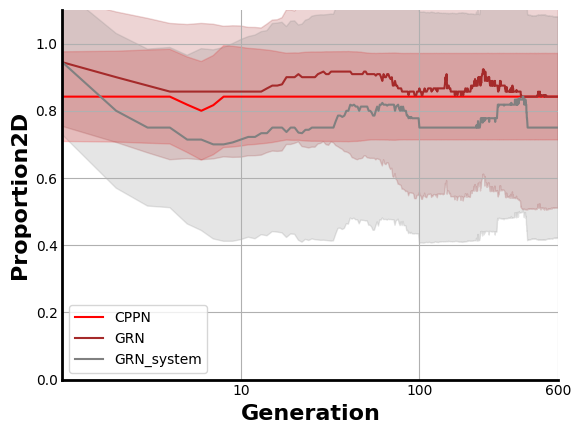

Proportion2D_adapted
Proportion2D_adapted
Proportion2D_adapted


C:\Users\niels\AppData\Local\Temp\ipykernel_4780\37756053.py:44: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  plt.xlim(0, 601)
C:\Users\niels\AppData\Local\Temp\ipykernel_4780\37756053.py:44: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  plt.xlim(0, 601)


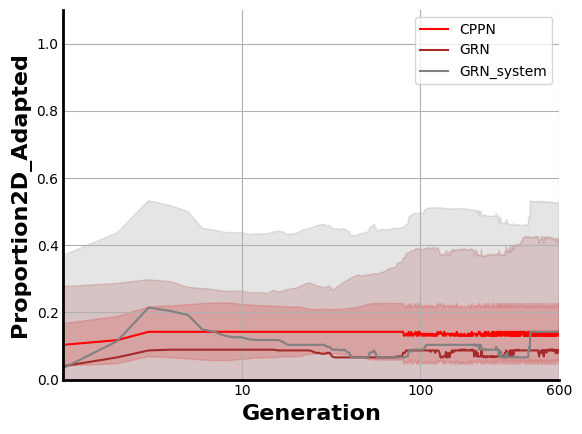

Single_Neighbour_Bricks
Single_Neighbour_Bricks
Single_Neighbour_Bricks


C:\Users\niels\AppData\Local\Temp\ipykernel_4780\37756053.py:44: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  plt.xlim(0, 601)
C:\Users\niels\AppData\Local\Temp\ipykernel_4780\37756053.py:44: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  plt.xlim(0, 601)


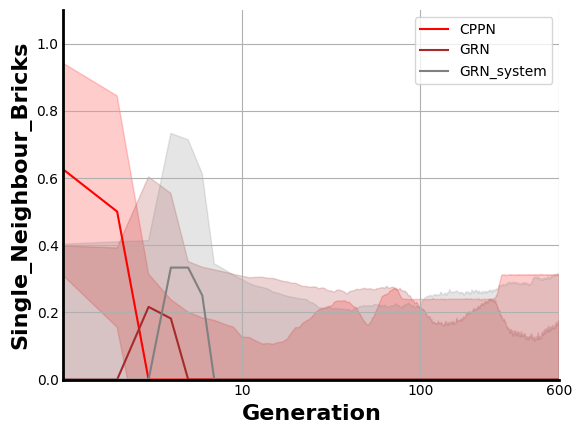

Single Neighbours
Single Neighbours
Single Neighbours


C:\Users\niels\AppData\Local\Temp\ipykernel_4780\37756053.py:44: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  plt.xlim(0, 601)
C:\Users\niels\AppData\Local\Temp\ipykernel_4780\37756053.py:44: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  plt.xlim(0, 601)


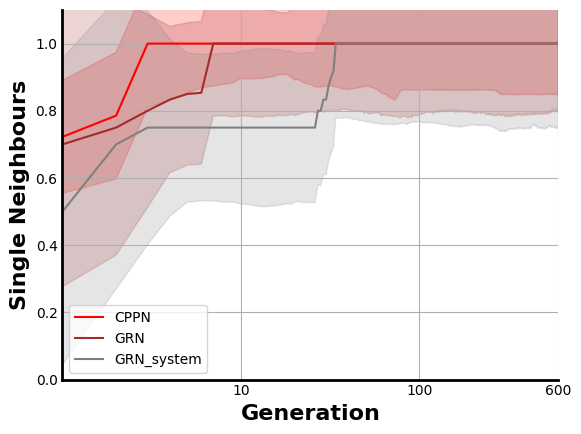

Double_Neighbours
Double_Neighbours
Double_Neighbours


C:\Users\niels\AppData\Local\Temp\ipykernel_4780\37756053.py:44: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  plt.xlim(0, 601)
C:\Users\niels\AppData\Local\Temp\ipykernel_4780\37756053.py:44: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  plt.xlim(0, 601)


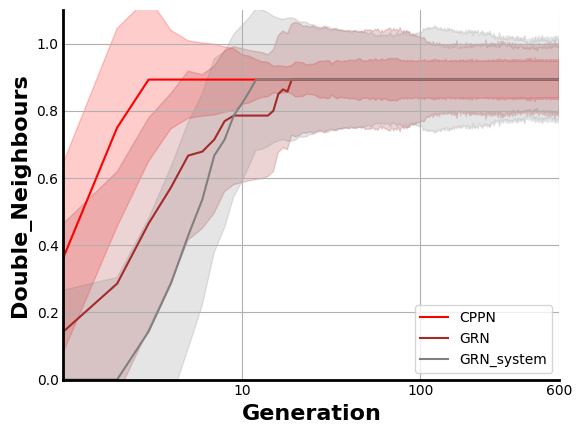

Attachment Length Max
Attachment Length Max
Attachment Length Max


C:\Users\niels\AppData\Local\Temp\ipykernel_4780\37756053.py:44: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  plt.xlim(0, 601)
C:\Users\niels\AppData\Local\Temp\ipykernel_4780\37756053.py:44: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  plt.xlim(0, 601)


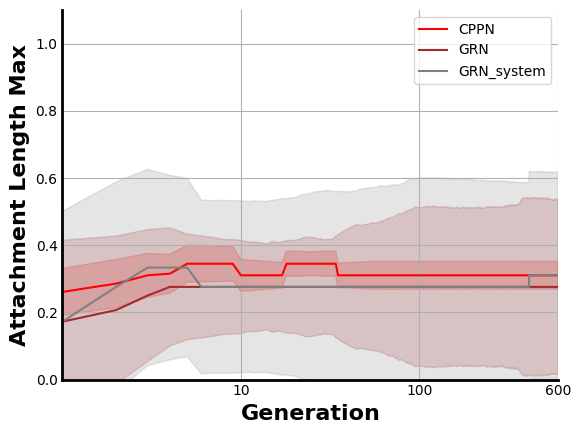

Attachment Length Mean
Attachment Length Mean
Attachment Length Mean


C:\Users\niels\AppData\Local\Temp\ipykernel_4780\37756053.py:44: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  plt.xlim(0, 601)
C:\Users\niels\AppData\Local\Temp\ipykernel_4780\37756053.py:44: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  plt.xlim(0, 601)


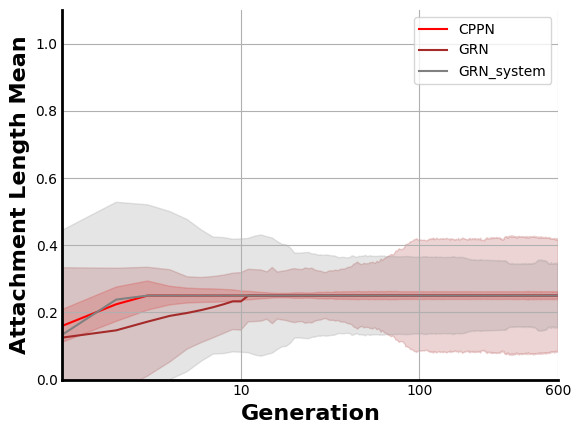

Attachment Length Std
Attachment Length Std
Attachment Length Std


C:\Users\niels\AppData\Local\Temp\ipykernel_4780\37756053.py:44: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  plt.xlim(0, 601)
C:\Users\niels\AppData\Local\Temp\ipykernel_4780\37756053.py:44: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  plt.xlim(0, 601)


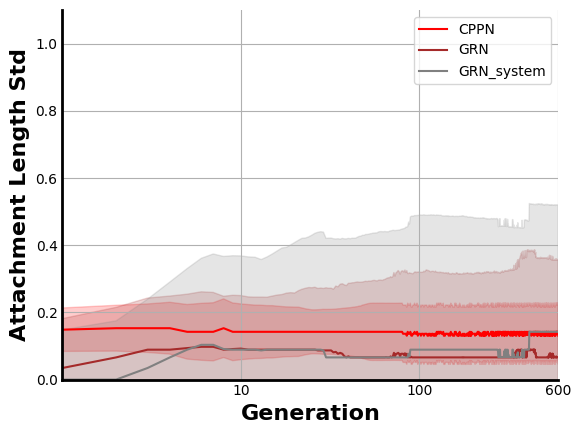

Core Attachments
Core Attachments
Core Attachments


C:\Users\niels\AppData\Local\Temp\ipykernel_4780\37756053.py:44: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  plt.xlim(0, 601)
C:\Users\niels\AppData\Local\Temp\ipykernel_4780\37756053.py:44: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  plt.xlim(0, 601)


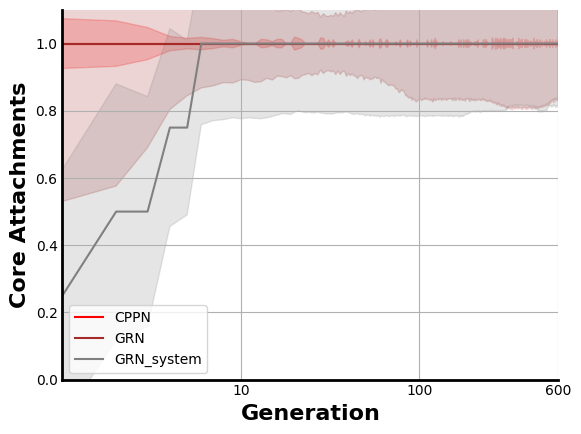

Number of Joints
Number of Joints
Number of Joints


C:\Users\niels\AppData\Local\Temp\ipykernel_4780\37756053.py:44: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  plt.xlim(0, 601)
C:\Users\niels\AppData\Local\Temp\ipykernel_4780\37756053.py:44: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  plt.xlim(0, 601)


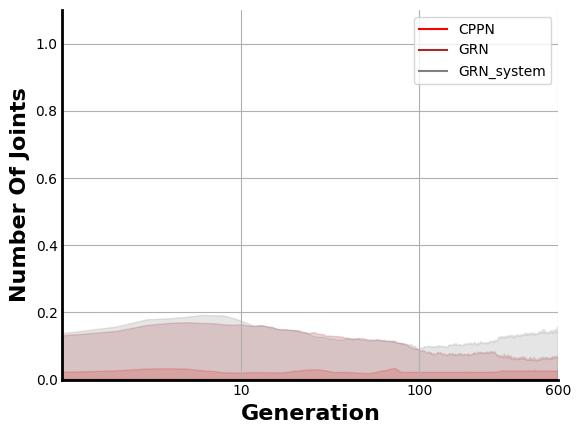

Joint-Brick Ratio
Joint-Brick Ratio
Joint-Brick Ratio


C:\Users\niels\AppData\Local\Temp\ipykernel_4780\37756053.py:44: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  plt.xlim(0, 601)
C:\Users\niels\AppData\Local\Temp\ipykernel_4780\37756053.py:44: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  plt.xlim(0, 601)


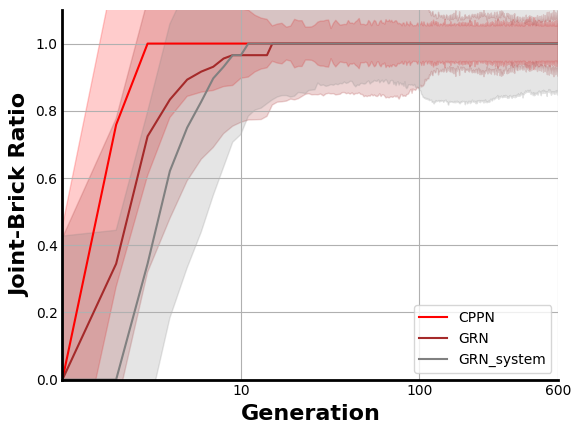

coverage
coverage
coverage


C:\Users\niels\AppData\Local\Temp\ipykernel_4780\37756053.py:44: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  plt.xlim(0, 601)
C:\Users\niels\AppData\Local\Temp\ipykernel_4780\37756053.py:44: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  plt.xlim(0, 601)


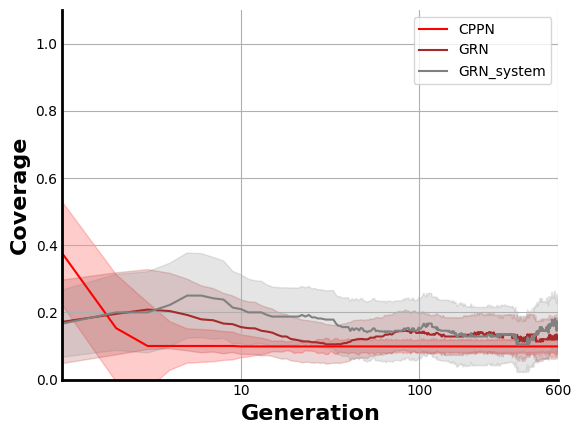

branching
branching
branching


C:\Users\niels\AppData\Local\Temp\ipykernel_4780\37756053.py:44: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  plt.xlim(0, 601)
C:\Users\niels\AppData\Local\Temp\ipykernel_4780\37756053.py:44: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  plt.xlim(0, 601)


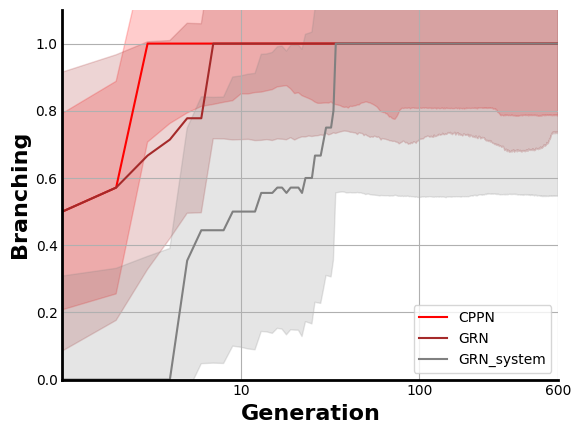

Surface Area
Surface Area
Surface Area


C:\Users\niels\AppData\Local\Temp\ipykernel_4780\37756053.py:44: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  plt.xlim(0, 601)
C:\Users\niels\AppData\Local\Temp\ipykernel_4780\37756053.py:44: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  plt.xlim(0, 601)


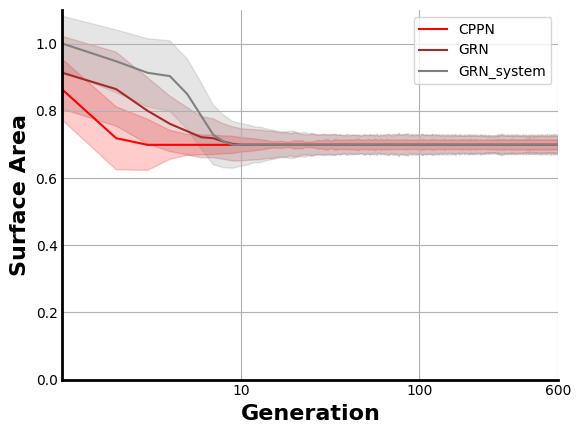

Symmetry_incl_max
Symmetry_incl_max
Symmetry_incl_max


C:\Users\niels\AppData\Local\Temp\ipykernel_4780\37756053.py:44: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  plt.xlim(0, 601)
C:\Users\niels\AppData\Local\Temp\ipykernel_4780\37756053.py:44: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  plt.xlim(0, 601)


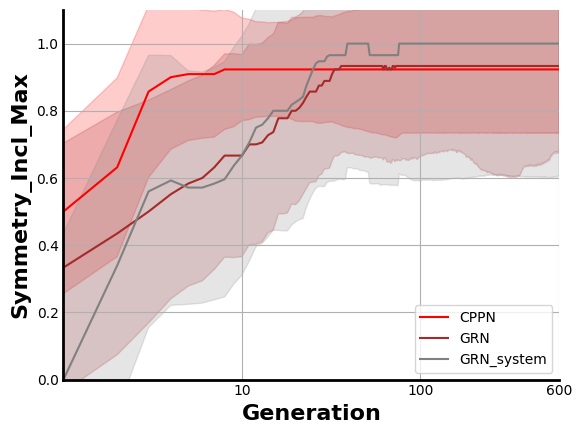

Symmetry_excl_max
Symmetry_excl_max
Symmetry_excl_max


C:\Users\niels\AppData\Local\Temp\ipykernel_4780\37756053.py:44: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  plt.xlim(0, 601)
C:\Users\niels\AppData\Local\Temp\ipykernel_4780\37756053.py:44: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  plt.xlim(0, 601)


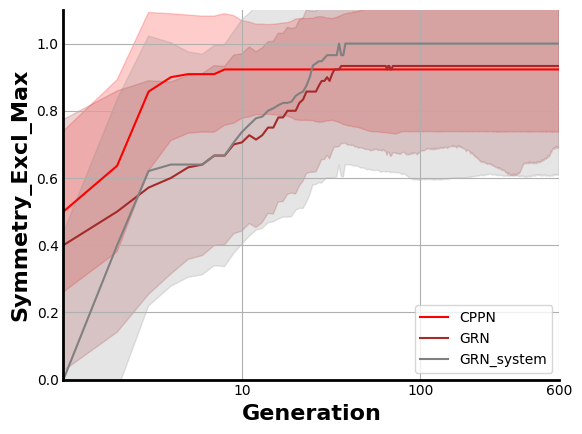

Symmetry_incl_median
Symmetry_incl_median
Symmetry_incl_median


C:\Users\niels\AppData\Local\Temp\ipykernel_4780\37756053.py:44: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  plt.xlim(0, 601)
C:\Users\niels\AppData\Local\Temp\ipykernel_4780\37756053.py:44: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  plt.xlim(0, 601)


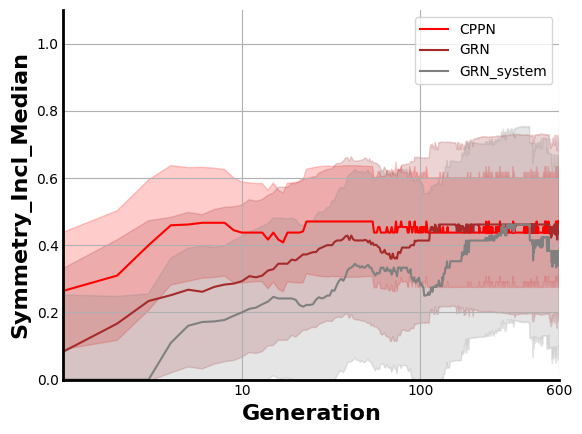

Symmetry_excl_median
Symmetry_excl_median
Symmetry_excl_median


C:\Users\niels\AppData\Local\Temp\ipykernel_4780\37756053.py:44: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  plt.xlim(0, 601)
C:\Users\niels\AppData\Local\Temp\ipykernel_4780\37756053.py:44: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  plt.xlim(0, 601)


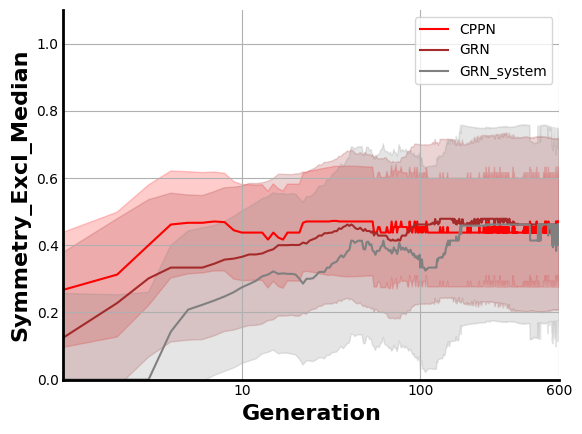

Symmetry_incl_sum
Symmetry_incl_sum
Symmetry_incl_sum


C:\Users\niels\AppData\Local\Temp\ipykernel_4780\37756053.py:44: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  plt.xlim(0, 601)
C:\Users\niels\AppData\Local\Temp\ipykernel_4780\37756053.py:44: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  plt.xlim(0, 601)


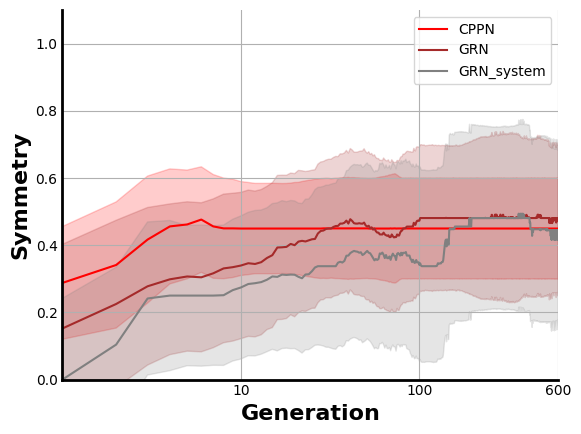

Symmetry_excl_sum
Symmetry_excl_sum
Symmetry_excl_sum


C:\Users\niels\AppData\Local\Temp\ipykernel_4780\37756053.py:44: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  plt.xlim(0, 601)
C:\Users\niels\AppData\Local\Temp\ipykernel_4780\37756053.py:44: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  plt.xlim(0, 601)


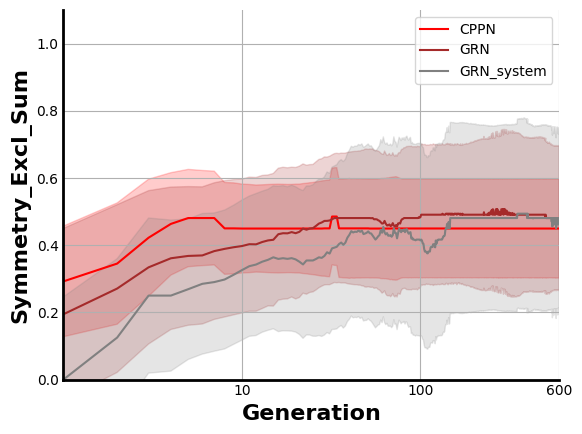

Symmetry_incl_std
Symmetry_incl_std
Symmetry_incl_std


C:\Users\niels\AppData\Local\Temp\ipykernel_4780\37756053.py:44: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  plt.xlim(0, 601)
C:\Users\niels\AppData\Local\Temp\ipykernel_4780\37756053.py:44: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  plt.xlim(0, 601)


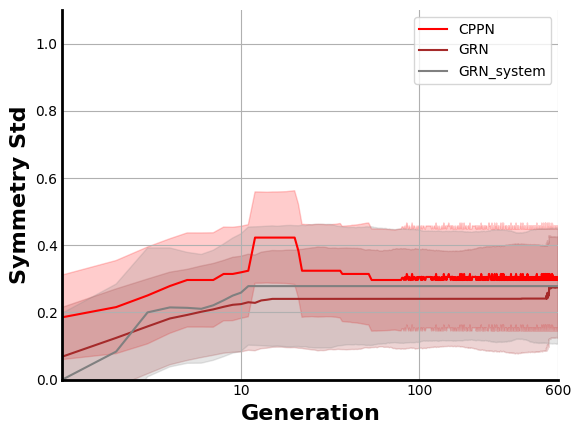

Symmetry_excl_std
Symmetry_excl_std
Symmetry_excl_std


C:\Users\niels\AppData\Local\Temp\ipykernel_4780\37756053.py:44: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  plt.xlim(0, 601)
C:\Users\niels\AppData\Local\Temp\ipykernel_4780\37756053.py:44: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  plt.xlim(0, 601)


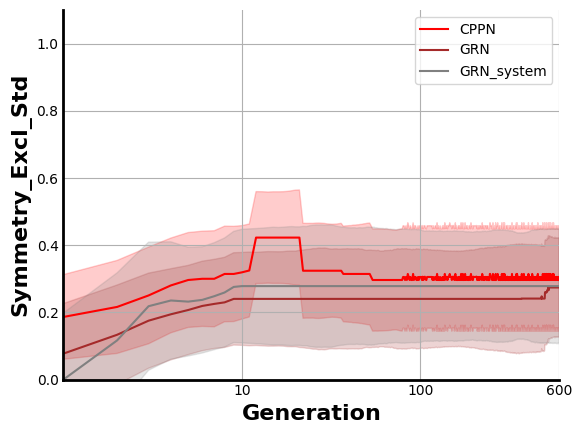

In [16]:
df_exp.rename(columns = {"Single_Neighbours": "Single Neighbours"}, inplace = True)

# ---- Group and apply
for mode in ["Evolution"]:
    medians = []
    for algo in ["CPPN", "GRN", "GRN_system"]:
        # Select data of algorithm and mode
        df_exp2 = df_exp.loc[df_exp["Algorithm"] == algo, :]
        df_exp2 = df_exp2.loc[df_exp2["Mode"] == mode, :]
        
        # Select even generations
        if mode == "Evolution":
            df_exp2 = df_exp2.loc[df_exp2["generation_index"] % 2 == 0, :]
            df_exp2.loc[:, "generation_index"] = (df_exp2.loc[:, "generation_index"] / 2).astype(int)
        else:
            pass

        # Group and apply
        cols4group = [col for col in df_exp2.columns if col not in colsn2plot or col in ["generation_index", "experiment_id"]]	
        median_exp = df_exp2.loc[:, cols4group].groupby(["generation_index"]).median()
        std_exp = df_exp2.loc[:, cols4group].groupby(["generation_index"]).std()

        # Append
        medians.append((median_exp, std_exp, algo))

    # ---- Plot
    cols2plot = [col for col in columns2plot if col not in ["id_string", "experiment_id", "generation_index", "individual_index"]]
    for col in cols2plot:
        lwb = min([(l[0][col] - l[1][col]).min() for l in medians])
        upb = max([(l[0][col] + l[1][col]).max() for l in medians])

        for ivals, vals in enumerate(medians):
            median_exp, std_exp, algo = vals
            color = {"GRN": "brown", "GRN_system": "grey", "CPPN": "red"}[algo]	
            alpha = {"GRN": 0.2, "GRN_system": 0.2, "CPPN": 0.2}[algo]
            # ---- Mean
            plt.plot(median_exp.index, median_exp.loc[:, col], label = algo, color = color)
            # Std
            plt.fill_between(median_exp.index, median_exp.loc[:, col] - std_exp.loc[:, col], median_exp.loc[:, col] + std_exp.loc[:, col], 
                             alpha = alpha, color = color)

            # Set limits
            if mode == "Evolution":
                plt.xlim(0, 601)
            else:
                plt.xlim(0, 51)
            plt.ylim(lwb - 0.1, upb + 0.1)

            # Set scale
            plt.xscale("log")

            # Set labels
            plt.xlabel("Generation", fontsize = 16, fontweight = "bold")
            print(col)
            if col not in ["Symmetry_incl_sum", "Symmetry_incl_std"]:
                plt.ylabel(col.title(), fontsize = 16, fontweight = "bold")
            elif col == "Symmetry_incl_sum":
                plt.ylabel("Symmetry", fontsize = 16, fontweight = "bold")
            elif col == "Symmetry_incl_std":
                plt.ylabel("Symmetry Std", fontsize = 16, fontweight = "bold")

            # Set thicker lines
            plt.gca().spines['left'].set_linewidth(2)
            plt.gca().spines['bottom'].set_linewidth(2)

            # Remove axes
            plt.gca().spines['top'].set_visible(False)
            plt.gca().spines['right'].set_visible(False)

            # Remove tick markers
            plt.tick_params(axis='both', which='both', length=0)

            # Set xtick labels
            plt.xticks([10, 100, 600], [10, 100, 600], fontsize = 10)
            plt.yticks(fontsize = 10)
            
            plt.legend()
            plt.grid()
        
        if col in ["Number of Hinges", "Number of Bricks"]:
            plt.ylim(0, 30)
        elif col in ["Modules"]:
            plt.ylim(1, 31)
        else:
            plt.ylim(0, 1.1)

        #fig.text(0.5, 0.04, 'Generation', ha='center', va='center')

        # Set common y-axis label
        #fig.text(0.06, 0.5, f'{col.title()}', ha='center', va='center', rotation='vertical')

        # Set common title
        #fig.suptitle(f'{col.title()}', fontsize=16)
        plt.show()
        #plt.savefig(f"{path_root}\\Plots\\LinePlots\\GRN vs CPPN\\{mode}" + f"\\{col}.png")
        #plt.close()


# Violin Plots non-evolution Data

In [ ]:
# for type_run in ["All", "Unique"]:
#     # Drop evolution data
#     df_exp2 = df_exp.loc[df_exp["Mode"] != "Evolution", :]

#     # ---- Violin plots
#     for col in columns2plot:
#         # Get data for violin plot
#         data4violin = []
#         # Select subset of data --> unique bodies or all? + column
#         for algo in df_exp2["Algorithm"].unique():
#             if algo == "Random": continue
#             if type_run == "Unique":
#                 sub_df = df_exp2.loc[df_exp2["Algorithm"] == algo, :].drop_duplicates(subset=['id_string'])
#                 sub_df = sub_df.loc[:, [col, "generation_index", 'Algorithm', 'Mode']]
#             else:
#                 sub_df = df_exp2.loc[df_exp2["Algorithm"] == algo, [col, "generation_index", 'Algorithm', 'Mode']]

#             # Set initialization
#             df4init = deepcopy(sub_df.loc[sub_df["generation_index"] == 0, :])
#             df4init.loc[:, "INIT"] = "Initialization"
#             sub_df.loc[:, "INIT"] = "Random Search"
#             sub_df = pd.concat([df4init, sub_df], axis=0, ignore_index=True)
#             # Append
#             data4violin.append(sub_df)
        
#         # Concat dfs
#         data4violin = pd.concat(data4violin, axis=0, ignore_index=True)

#         # Group data
#         # Plot
#         sns.violinplot(data4violin, x = "Algorithm", y = col, hue = "INIT", split=True, gap=0, inner="quart")
#         plt.xlabel("Algorithm", fontsize = 12, fontweight = 'bold')
#         plt.ylabel(col.title(), fontsize = 12, fontweight = 'bold')
#         plt.title(col.title(), fontsize = 14, fontweight = 'bold')
#         # Remove right and top spines
#         sns.despine()
#         plt.tight_layout()
#         plt.savefig(f"{path_root}\\Plots\\Violin\\GRN vs CPPN\\Random Search" + f"\\{type_run}\\{col}.png")
#         plt.close()

In [ ]:
print(df_exp["Symmetry_incl_sum"].min())

In [ ]:
#mode = "Random Search"
mode = "Evolution"
# Initialize
if mode == "Evolution":
    fig, ax = plt.subplots(3, 1, figsize=(30, 30))
else:
    fig, ax = plt.subplots(4, 1, figsize=(30, 30))
plt.subplots_adjust(hspace=1)

# for mode in ["Evolution", "Random Search"]:
# Drop evolution data
df_exp2 = df_exp.loc[df_exp["Mode"] == mode, :]
if mode == "Evolution":
    df_exp2 = df_exp2.loc[df_exp2["generation_index"] == 1200, :]

# Append random data n times
rows = []
temporarydf = df_exp2.loc[df_exp2["Algorithm"] == "Random", :]
temporarydf = temporarydf.loc[temporarydf["count"] > 1, :]

for irow, row in temporarydf.iterrows():
    if row["count"] != 1:
        rows += [row] * int(row["count"] - 1)
        
repeated_df = pd.DataFrame(rows).reset_index(drop=True)
df_exp2 = pd.concat([df_exp2, repeated_df], axis=0, ignore_index=True)

# ---- Violin plots
if mode == "Evolution":
    algos = ["CPPN", "GRN", "GRN_system"]
else:
    algos = ["Random", "CPPN", "GRN", "GRN_system"]
for ialgo, algo in enumerate(algos):
    # Get data for violin plot
    data4violin = []
    for col in ["Relative Number of Modules", "Joint-Brick Ratio", "Number of Limbs", "Single_Neighbours",
                "Maximal Length of Limbs", "Mean Length of Limbs", "Standard Deviation of Limbs", "Number of Joints",
                "surface_area", 'Symmetry_incl_sum', "Symmetry_incl_std",
                ]:

        # Select subset of data --> unique bodies or all? + column
        for type_run in ["All", "Unique"]:
            if type_run == "Unique":
                sub_df = df_exp2.loc[df_exp2["Algorithm"] == algo, :].drop_duplicates(subset=['id_string'])
                sub_df = sub_df.loc[:, [col, "generation_index"]]
            else:
                sub_df = df_exp2.loc[df_exp2["Algorithm"] == algo, [col, "generation_index"]]

            # Transform
            sub_df[col] = (sub_df[col] - df_exp[col].min()) / (df_exp[col].max() - df_exp[col].min())
            # Append
            sub_df.rename(columns={col: "Variable"}, inplace=True)
            sub_df["column_label"] = col
            sub_df["Type"] = type_run
            data4violin.append(sub_df)
    
    # Concat dfs
    data4violin = pd.concat(data4violin, axis=0, ignore_index=True)

    # Group data
    # Plot
    sns.violinplot(data4violin, x = "column_label", y = "Variable", split=True, hue = "Type", gap=0, inner="quart",
                   scale = "width", ax = ax[ialgo])
    ax[ialgo].set_xlabel("")
    ax[ialgo].set_ylabel("")
    
    if ialgo == 0:
        ax[ialgo].set_xticklabels(["Modules", "Joint-Brick Ratio", "Core Attachments", 
                    "Single Neighbours", "Number of Joints", 
                    "Attachment Length Max", "Attachment Length Mean", "Attachment Length Std",
                    "Surface Area", 'Symmetry', "Symmetry Std",
                    ], rotation = 90, fontsize = 20, fontweight = 'bold')
        ax[ialgo].tick_params(top=True, labeltop=True, bottom=False, labelbottom=False, pad = 60,
                              left = False)
    elif (ialgo == 3) or (ialgo == 2 and mode == "Evolution"): 
        ax[ialgo].set_xticklabels(["Modules", "Joint-Brick Ratio", "Core Attachments", 
                    "Single Neighbours", "Number of Joints", 
                    "Attachment Length Max", "Attachment Length Mean", "Attachment Length Std",
                    "Surface Area", 'Symmetry', "Symmetry Std",
                    ], rotation = 90, fontsize = 20, fontweight = 'bold')
        ax[ialgo].tick_params(pad = 60, left = False)
    else:
        ax[ialgo].set_xticklabels([])
        ax[ialgo].tick_params(pad = 60, left = False)

    ax[ialgo].set_ylim(0, 1)
    ax[ialgo].set_yticklabels(["" for tick in ax[ialgo].get_yticks()], fontsize = 20, fontweight = 'bold')
    #ax[ialgo].set_yticklabels([tick.round(2) for tick in ax[ialgo].get_yticks()], fontsize = 20, fontweight = 'bold')
    ax[ialgo].set_title(algo, fontsize = 30, fontweight = 'bold', pad = 20, y= 1.0, loc = "center")
    
    # Remove right and top spines
    sns.despine(top = True, right = True, left = True)
    ax[ialgo].legend().remove()
    plt.tight_layout()
    #plt.savefig(f"{path_root}\\Plots\\Violin\\GRN vs CPPN\\Random Search" + f"\\{type_run}\\{col}.png")
    #plt.close()
plt.show()

# Violin Plots over Time (Offspring Only)

In [ ]:
for type_run in ["All", "Unique"]:

    # Drop non-evolution data
    df_exp2 = df_exp.loc[df_exp["Mode"] == "Evolution", :]
    # Select only uneven generations
    df_exp2 = df_exp2.loc[df_exp2["generation_index"] % 2 != 0, :]
    df_exp2.loc[:, "generation_index"] = df_exp2.loc[:, "generation_index"].values - (df_exp2.loc[:, "generation_index"].values // 2)
    df_exp3 = deepcopy(df_exp2)
    # ---- Set generation index in steps of 0, 10, 20, 30, 40, 50, 100, 150, 200, 300, 400, 500, 600
    # Where generation index < 10 --> 5
    df_exp3.loc[df_exp2["generation_index"] <= 600, "generation_index"] = "301-600"
    df_exp3.loc[df_exp2["generation_index"] <= 300, "generation_index"] = "101-300"
    df_exp3.loc[df_exp2["generation_index"] <= 100, "generation_index"] = "51-100"
    df_exp3.loc[df_exp2["generation_index"] <= 50, "generation_index"] = "26-50"
    df_exp3.loc[df_exp2["generation_index"] <= 25, "generation_index"] = "0-25"

    # ---- Violin plots
    for col in columns2plot:
        # Get data for violin plot
        data4violin = []
        # Select subset of data --> unique bodies or all? + column
        for algo in df_exp3["Algorithm"].unique():
            if type_run == "Unique":
                sub_df = df_exp3.loc[df_exp3["Algorithm"] == algo, :].drop_duplicates(subset=['id_string'])
                sub_df = sub_df.loc[:, [col, "generation_index", 'Algorithm', 'Mode']]
            else:
                sub_df = df_exp3.loc[df_exp3["Algorithm"] == algo, [col, "generation_index", 'Algorithm', 'Mode']]
    
            # Append
            data4violin.append(sub_df)
        
        # Concat dfs
        data4violin = pd.concat(data4violin, axis=0, ignore_index=True)

        # Group data
        # Plot

        sns.violinplot(data4violin, x = "generation_index", y = col, hue = "Algorithm", split=True, gap=0, inner="quart",
                       order = ["0-25", "26-50", "51-100", "101-300", "301-600"])
        plt.xlabel("Algorithm", fontsize = 12, fontweight = 'bold')
        plt.ylabel(col.title(), fontsize = 12, fontweight = 'bold')
        plt.title(col.title(), fontsize = 14, fontweight = 'bold')
        # Remove right and top spines
        sns.despine()
        plt.tight_layout()
        
        plt.savefig(f"{path_root}\\Plots\\Violin\\GRN vs CPPN\\Evolution\\{type_run}\\Offspring" + f"\\{col}.png")
        plt.close()

#https://plotly.com/python/v3/density-plots/

In [ ]:
# # Assuming 'measures_heat', 'generation', 'rank', and 'value' are your data and columns
# # Replace these with your actual data and column names
for algo in ["GRN", "CPPN"]:
    for mode in ["Evolution"]:
        # Select data
        df2 = df_exp.loc[df_exp["Mode"] == mode, :]
        df2 = df2.loc[df_exp["Algorithm"] == algo, :]

        if mode == "Evolution":
            # Select only even generations
            df2 = df2.loc[df2["generation_index"] % 2 == 0, :]
            df2.loc[:, "generation_index"] = (df2.loc[:, "generation_index"] / 2).astype(int)
        else:
            pass

        for col in columns2plot:
            # Get a column for each row according to rank within generation based on col
            df2["rank"] = df2.groupby("generation_index")[col].rank(method='first', ascending=True)
            df2pivot = df2.pivot(index = "rank", columns = "generation_index", values = col)
            # Create the heatmap plot
            heat = sns.heatmap(df2pivot, 
                            cmap='inferno', 
                            linewidths=0, 
                            linecolor='white', vmin = df_exp[col].min(), vmax = df_exp[col].max())
            
            # Set the axis labels and title
            heat.set_xlabel('Generations', fontsize=16)
            heat.set_ylabel("Robots", fontsize=16)
            heat.set_title(col.title(), fontsize=16)

            # # Set x-axis ticks
            if mode == "Evolution":
                heat.set_xticks([0, 100, 200, 300, 400, 500, 600])
                heat.set_xticklabels([0, 100, 200, 300, 400, 500, 600])
            else:
                heat.set_xticks([0, 10, 20, 30, 40, 50])
                heat.set_xticklabels([0, 10, 20, 30, 40, 50])

            # Remove y-axis ticks
            heat.set_yticks([])

            # Adjusting the plot layout
            plt.subplots_adjust(top=0.9, right=0.9)

            # Save the plot
            plt.savefig(f"{path_root}\\Plots\\HeatMap\\Line\\{mode}\\{algo}\\{col}.png")
            plt.close()

# Violin Plots over Time (Population only)

In [ ]:
for type_run in ["All", "Unique"]:
    # Drop non-evolution data
    df_exp2 = df_exp.loc[df_exp["Mode"] == "Evolution", :]
    # Select only even generations
    df_exp2 = df_exp2.loc[df_exp2["generation_index"] % 2 == 0, :]
    df_exp2.loc[:, "generation_index"] = (df_exp2.loc[:, "generation_index"].values / 2).astype(int)
    df_exp3 = deepcopy(df_exp2)

    # Select where generation_index in  [0, 25, 50, 100, 300, 600]
    df_exp3 = df_exp3.loc[df_exp3["generation_index"].isin([0, 25, 50, 100, 300, 600]), :]

    # ---- Violin plots
    for col in columns2plot:
        # Get data for violin plot
        data4violin = []
        # Select subset of data --> unique bodies or all? + column
        for algo in df_exp3["Algorithm"].unique():
            if type_run == "Unique":
                sub_df = df_exp3.loc[df_exp3["Algorithm"] == algo, :].drop_duplicates(subset=['id_string'])
                sub_df = sub_df.loc[:, [col, "generation_index", 'Algorithm', 'Mode']]
            else:
                sub_df = df_exp3.loc[df_exp3["Algorithm"] == algo, [col, "generation_index", 'Algorithm', 'Mode']]
    
            # Append
            data4violin.append(sub_df)
        
        # Concat dfs
        data4violin = pd.concat(data4violin, axis=0, ignore_index=True)

        # Group data
        # Plot

        sns.violinplot(data4violin, x = "generation_index", y = col, hue = "Algorithm", split=True, gap=0, inner="quart",
                       order = [0, 25, 50, 100, 300, 600])
        plt.xlabel("Algorithm", fontsize = 12, fontweight = 'bold')
        plt.ylabel(col.title(), fontsize = 12, fontweight = 'bold')
        plt.title(col.title(), fontsize = 14, fontweight = 'bold')
        # Remove right and top spines
        sns.despine()
        plt.tight_layout()
        
        plt.savefig(f"{path_root}\\Plots\\Violin\\GRN vs CPPN\\Evolution\\{type_run}\\Population"+ f"\\{col}.png")
        plt.close()

# Densities Across Runs (Random Search)

In [ ]:
for algo in df_exp["Algorithm"].unique():
      df2 = df_exp.loc[df_exp["Mode"] == "Random Search", :]
      df2 = df2.loc[df_exp["Algorithm"] == algo, :]
      for col in columns2plot:
            # Initialize the FacetGrid object
            pal = sns.cubehelix_palette(10, rot=-.25, light=.7)
            g = sns.FacetGrid(df2, row="experiment_id", hue="experiment_id", aspect=15, height=1, palette=pal)


            # Draw the densities in a few steps
            g.map(sns.kdeplot, col,
                  bw_adjust=.5, clip_on=False,
                  fill=True, alpha=1, linewidth=1.5)
            g.map(sns.kdeplot, col, clip_on=False, color="w", lw=2, bw_adjust=.5)

            # passing color=None to refline() uses the hue mapping
            g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)


            # Define and use a simple function to label the plot in axes coordinates
            def label(x, color, label):
                  ax = plt.gca()
                  ax.text(-0.2, .2, label, fontweight="bold", color=color,
                              ha="left", va="center", transform=ax.transAxes)


            g.map(label, col)

            # Set the subplots to overlap
            g.figure.subplots_adjust(hspace=0)#-.25)

            # Remove axes details that don't play well with overlap
            g.set_titles("")
            g.set(yticks=[], ylabel="")
            g.despine(bottom=True, left=True)
            plt.savefig(f"{path_root}\\Plots\\Niches\\Across_Runs\\Random Search\\{algo}" + f"\\{col}.png")
            plt.close()

# Niches Median

In [ ]:
def get_accumulated_phenotypes(df):
    accumulated = [0]
    database = []
    for gen in df["generation_index"].unique():
        # Get unique phenotypes in generation
        unique_phenotypes = df.loc[df_exp["generation_index"] == gen, "id_string"].unique().tolist()
        # Amount not in database
        not_in_db = len(set(unique_phenotypes) - set(database))
        # Add to accumulated
        accumulated.append(accumulated[-1] + not_in_db)
        # Add to database
        database = list(set(database) | set(unique_phenotypes))
    return accumulated


# ---- For all experiments separately: Random Search & Evolution
for mode in ["Random Search", "Evolution"]:
    for algo in df_exp["Algorithm"].unique():
        accdata = []
        # Get algo and Mode = Random Search
        df_exp2 = df_exp.loc[df_exp["Algorithm"] == algo, :]
        df_exp2 = df_exp2.loc[df_exp2["Mode"] == mode, :]

        for exp in df_exp2["experiment_id"].unique():
            accdata.append(get_accumulated_phenotypes(df_exp2.loc[df_exp["experiment_id"] == exp])[1:])

        plt.plot(np.median(accdata, axis = 0), "-", label = algo)
        plt.fill_between(range(len(accdata[0])), np.median(accdata, axis = 0) - np.std(accdata, axis = 0), np.median(accdata, axis = 0) + np.std(accdata, axis = 0), alpha = 0.2)
    plt.xlabel("Generation", fontsize = 16, fontweight = 'bold')
    plt.ylabel("Unique phenotypes", fontsize = 16, fontweight = 'bold')
    plt.title(f"Unique Phenotypes over Time for {mode}", fontsize = 16, fontweight = 'bold')
    plt.grid()
    plt.tight_layout()
    plt.legend()
    plt.savefig(f"{path_root}\\Plots\\Niches\\{mode}" + f"\\accumulated phenotypes median.png")
    plt.close()

# Niches Total

In [ ]:
# ---- For all experiments together
for mode in ["Random Search", "Evolution"]:
    for algo in df_exp["Algorithm"].unique():
        accdata = []
        # Get algo and Mode = Random Search
        df_exp2 = df_exp.loc[df_exp["Algorithm"] == algo, :]
        df_exp2 = df_exp2.loc[df_exp2["Mode"] == mode, :]
        # Get accumulated phenotypes
        accdata = get_accumulated_phenotypes(df_exp2)[1:]
        # Plot
        plt.plot(accdata, "-", label = algo)

    plt.xlabel("Generation", fontsize = 16, fontweight = 'bold')
    plt.ylabel("Unique phenotypes", fontsize = 16, fontweight = 'bold')
    plt.title(f"Unique Phenotypes over Time for {mode}", fontsize = 16, fontweight = 'bold')
    plt.grid()
    plt.tight_layout()
    plt.legend()
    plt.savefig(f"{path_root}\\Plots\\Niches\\{mode}" + f"\\accumulated phenotypes total.png")
    plt.close()

# Niches Sorted

In [ ]:
# Initialize
max_x = 0
max_y = 0

for type_scale in ["log"]:
    for algo in ["CPPN", "GRN", "GRN_system"]:
        df_exp2 = df_exp.loc[df_exp["Algorithm"] == algo, :]
        df_exp2 = df_exp2.loc[df_exp2["Mode"] == "Random Search", :]
        # ---- Get plots        
        # Get counts of id_strings, sort by count and plot
        phenotype_counts = df_exp2["id_string"].value_counts()
        phenotype_counts.sort_values(ascending = False, inplace = True)
        # Plot
        if algo == "CPPN":
            color = "k"
            dash = "-"
        elif algo == "GRN":
            color = "grey"
            dash = "-"
        else:
            color = "k"
            dash = "--"
        plt.plot(phenotype_counts.values, dash, color = color, label = algo)

        # Add arrow
        xloc = (phenotype_counts.values.shape[0] - 1)
        logdistance = (np.log(xloc + 1) - np.log(xloc - 1))
        plt.arrow(xloc, 1, 0, 9,
                   head_width = 0.3 / logdistance, head_length = 3, fc = color, ec = color, linestyle = dash)
        plt.text(xloc, 15, algo, fontsize = 6, color = "k", ha = "center")

        # ---- Save max values
        if phenotype_counts.values.shape[0] > max_x:
            max_x = phenotype_counts.values.shape[0]
        if max(phenotype_counts.values) > max_y:
            max_y = max(phenotype_counts.values)
    
    plt.xlabel("IDs", fontsize = 16, fontweight = 'bold')
    plt.ylabel("Frequency", fontsize = 16, fontweight = 'bold')
    plt.xscale(type_scale)
    plt.yscale(type_scale)
    plt.xlim(0, max_x + 6000)
    plt.ylim(0, max_y)
    #plt.savefig(f"{path_root}\\Plots\\Niches\\Random Search" + f"\\phenotype counts_{type_scale}_{algo}.png")
    plt.legend()
    plt.grid()
    plt.tight_layout()
    # Remove upper and right spines
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['top'].set_visible(False)
    # Remove minor ticks
    plt.gca().xaxis.set_minor_locator(plt.NullLocator())
    plt.gca().yaxis.set_minor_locator(plt.NullLocator())
    # Remove ticks but keep labels
    plt.tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False)

    # Set thicker spines
    ax = plt.gca()
    ax.spines['top'].set_linewidth(2)
    ax.spines['bottom'].set_linewidth(2)
    ax.spines['left'].set_linewidth(2)
    ax.spines['right'].set_linewidth(2)

    plt.show()


# Bodies to Grid

In [35]:
from develop_from_string import get_body
from itertools import product
from revolve2.modular_robot.body.v2 import ActiveHingeV2, BrickV2
from revolve2.modular_robot.body.base._core import Core
from revolve2.modular_robot.body.v2._attachment_face_core_v2 import AttachmentFaceCoreV2


def create_plot(grid, z = 0):
    """Goal:
        Create a plot of the robot.
    -------------------------------------------------------
    Input:
        grid: The grid of the robot
    -------------------------------------------------------
    Output:
        A plot of the robot."""
    # Create a copy
    newgrid = deepcopy(grid)
    
    # Fill the new grid
    for x, y in product(range(grid.shape[0]), range(grid.shape[1])):
        if type(grid[x, y, z + 1]) == BrickV2:
            newgrid[x, y, z] = 3
        elif type(grid[x, y, z + 1]) == ActiveHingeV2:
            newgrid[x, y, z] = 2
        elif type(grid[x, y, z + 1]) == AttachmentFaceCoreV2:
            newgrid[x, y, z] = 1
        elif type(grid[x, y, z + 1]) == Core:
            newgrid[x, y, z] = 1
        else:
            newgrid[x, y, z] = 0
    
    return newgrid[:, :, z].astype(int)

def string2grid(string):
    # Get max_parts
    splitted = string.split("|")
    max_parts = int(splitted[0])
    # Only core? or should we get the building plan?
    if max_parts == 1:
        dict_coord = None
    elif len(splitted) == 2:
        # ---- Get coordinate data
        substring = splitted[1]
        substring_split = substring.split("-")
        # Fill dictionary with building plan
        # --> {poslin: ["B" or "H", {attachment_point: rotation_index}]}
        dict_coord = {}
        i = 0
        while (i != len(substring_split)) and (substring_split[i] != ""):
            # Linear coordinate
            coord = int(substring_split[i])
            # Information for that coordinate (type, attachment points and orientations)
            info = substring_split[i + 1]
            # Set type of module (Brick or Hinge)
            dict_coord[coord] = []
            dict_coord[coord].append(info[0])
            # Set attachment points and orientations
            if len(info[1:]) > 1:
                dict_coord[coord].append({})
                for j in range(int((len(info) - 1) / 2)):
                    dict_coord[coord][1][int(info[1 + int(j * 2)])] = int(info[1 + (int(j * 2) + 1)])
            else:
                dict_coord[coord].append({})
            # Increase i
            i += 2
    
    # ---- Develop body
    body = get_body(max_parts, dict_coord)

    # ---- Get Grid
    grid, core_grid_position, id_string = body.to_grid(ActiveHingeV2, BrickV2)
    assert string == id_string, "Error in string to grid conversion"

    # ---- Grid to image
    grid = create_plot(grid)
            
    return grid, core_grid_position



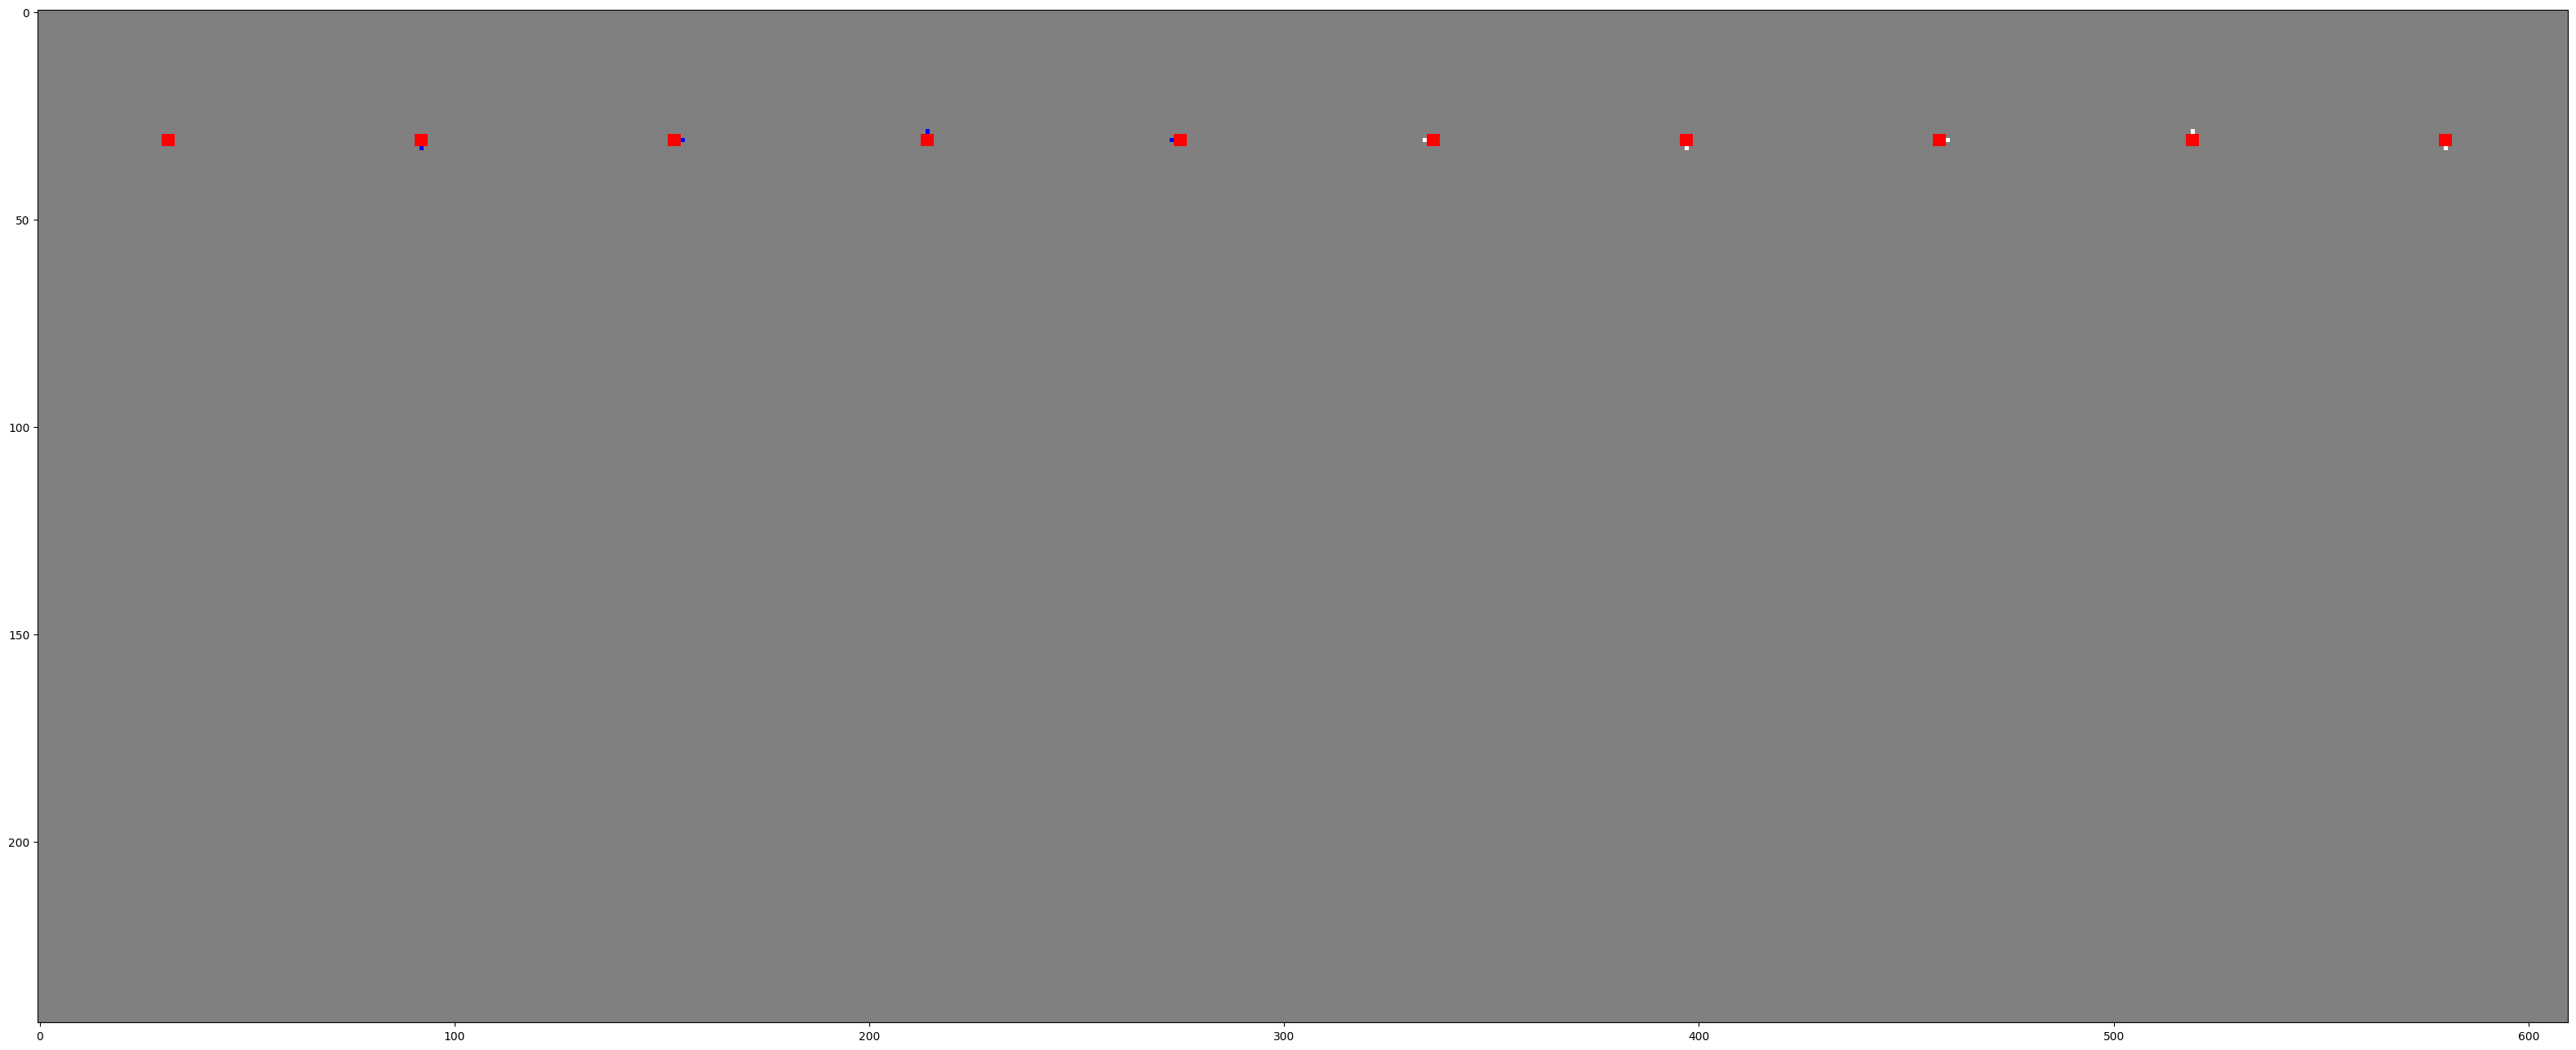

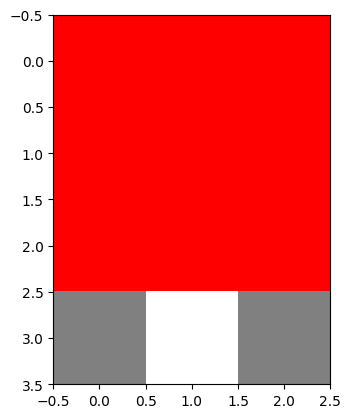

[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]


In [56]:
nbodies = 10
nalgos = 4
matrix = np.zeros((nalgos * 61, nbodies * 61)).astype(int) # (29 * 2) + 3 = 61
plt.figure(figsize = (40, 40))

# Get data
df = df_exp.loc[df_exp["Algorithm"] == "Random", :]
# Sort df by count
df = df.sort_values("count", ascending = False, ignore_index = True, inplace = False)

for istring, string in enumerate(df["id_string"][0:nbodies]):
    ialgo = 0
    # Get grid
    grid, core_grid_position = string2grid(string)
    # Fill matrix where center is core_grid_position at 16, 16
    rows, cols = grid.shape
    shift1 = 31 - core_grid_position[0]
    shift2 = 31 - core_grid_position[1]


    matrix[ialgo * 61 + shift1:ialgo * 61 + shift1 + rows, 
           istring * 61 + shift2:istring * 61 + shift2 + cols] = grid
    
    



# Create a custom colormap with 4 colors
cmap = plt.cm.colors.ListedColormap(['grey', 'red', 'white', 'blue'])

# Create a normalized color map
norm = plt.cm.colors.Normalize(vmin = 0, vmax = 3)
# plot the matrix
plt.imshow(matrix, cmap = cmap, norm = norm, interpolation = 'none', aspect = "equal", )
plt.show()
plt.imshow(grid, cmap = cmap, norm = norm)
plt.show()

print(matrix[20:40, -40:-20])
